In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [3]:
from torchvision import datasets, models, transforms, utils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.misc as msc
from PIL import Image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
batch_size = 64
lr = 0.001

D_ent = 100
D_length = 28
D_img = D_length ** 2
D_hidden = 28

torch.manual_seed(6125)

In [7]:
trans = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))])

In [8]:
data = datasets.MNIST(root='../data/', train=True, transform=trans)

In [9]:
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
def mnist():
    data = next(iter(data_loader))[0]
    return data.view(batch_size, D_img)

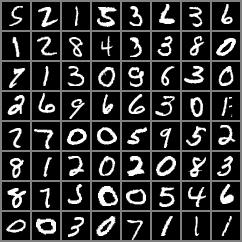

In [11]:
inputs = mnist().data.resize_(batch_size, 1, D_length, D_length)
out = utils.make_grid(inputs)
msc.toimage(out)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200,1)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.1)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.1)
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 784)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc3(x)
        x = F.tanh(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [14]:
def get_sample_image(G, n_noise=100):
    s = torch.manual_seed(114514)
    for num in range(10):
        for i in range(10):
            z = torch.randn(1, n_noise).to(device)
            y_hat = G(z)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    return img

In [15]:
D = Discriminator().to(device)
G = Generator().to(device)

In [16]:
criterion = nn.BCELoss()

In [17]:
D_opt = optim.Adam(D.parameters(), lr=lr)
G_opt = optim.Adam(G.parameters(), lr=lr)

In [18]:
ones = torch.ones(batch_size).to(device)
zeros = torch.zeros(batch_size).to(device)

In [19]:
step = 0
max_epoch = 100
dis_step = 3
log_interval = 1000

In [20]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        step += 1
        # ------D trainning------
        x = images.to(device)
        x_out = D(x)
        x_loss = criterion(x_out, ones)
        z = torch.randn(batch_size, 100).to(device)
        z_out = D(G(z))
        z_loss = criterion(z_out, zeros)
        D_loss = x_loss + z_loss
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % dis_step == 0:
            # ------G trainning------
            z = torch.randn(batch_size, 100).to(device)
            z_out = D(G(z))
            G_loss = criterion(z_out, ones)
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
    # ------save------
    with torch.no_grad():
        G.eval()
        img = get_sample_image(G)
        msc.imsave("{:02d}_train.jpg".format(epoch), img)
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, 
                max_epoch, step, D_loss.data.item(), G_loss.data.item()))

Epoch: 0/100, Step: 937, D Loss: 0.05289538577198982, G Loss: 8.4485445022583
Epoch: 1/100, Step: 1874, D Loss: 0.0031195308547466993, G Loss: 8.665863990783691
Epoch: 2/100, Step: 2811, D Loss: 0.06798902899026871, G Loss: 4.374168395996094
Epoch: 3/100, Step: 3748, D Loss: 0.15815624594688416, G Loss: 4.909106254577637
Epoch: 4/100, Step: 4685, D Loss: 0.1307295858860016, G Loss: 4.307472229003906
Epoch: 5/100, Step: 5622, D Loss: 0.23672857880592346, G Loss: 3.320154905319214
Epoch: 6/100, Step: 6559, D Loss: 0.43843087553977966, G Loss: 3.29794979095459
Epoch: 7/100, Step: 7496, D Loss: 0.37156057357788086, G Loss: 3.1952428817749023
Epoch: 8/100, Step: 8433, D Loss: 0.5436969995498657, G Loss: 2.5729317665100098
Epoch: 9/100, Step: 9370, D Loss: 0.48141852021217346, G Loss: 2.6150834560394287
Epoch: 10/100, Step: 10307, D Loss: 0.5839937925338745, G Loss: 3.23620867729187
Epoch: 11/100, Step: 11244, D Loss: 0.502494215965271, G Loss: 2.224320650100708
Epoch: 12/100, Step: 12181, D